In [1]:
import numpy as np
from random import randint, seed
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import time
from PIL import Image
from IPython import display

# SET THESE VARIABLES

In [2]:
img_name = "test_img.jpg" # the image filename
smoothing_iter = 10 # the smoothing factor
max_iter = 5 # k-means iterations until termination
K = 3 # number of clusters

# SCRIPT IS BELOW (DO NOT CHANGE)

### Load image as array

In [3]:
def load_image(filename):
    img = Image.open(filename)
    data = np.asarray(img, dtype='int32') # convert to array
    return data, img

In [4]:
# get image array
img_arr, img_orig = load_image(img_name)

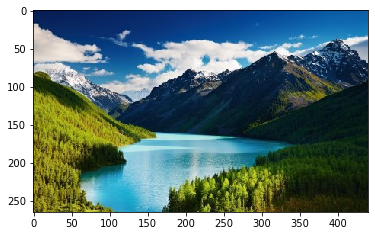

In [5]:
plt.imshow(img_arr)

### View array

In [6]:
img_arr.shape

(265, 440, 3)

### Reshape array to 2D

In [7]:
# make each row a pixel
# col0 = R, col1 = G, col2 = B
X = img_arr.reshape(img_arr.shape[0]*img_arr.shape[1], 3)

In [8]:
X.shape

(116600, 3)

### Preprocess

In [9]:
# convert pixels to floats
X = np.float32(X)

### Randomly initialize centroids

In [10]:
def kmeans_init_centroids(X, K, ran_seed):
    
    seed(ran_seed)
    
    # only include unique colors
    X_uniq = [tuple(row) for row in X]
    X_uniq = np.unique(X_uniq, axis=0)
    
    # store centroids in Kxn
    centroids = np.zeros((K, X.shape[1]))
    
    # randomly select unique values
    for i in range(K):
        color = X_uniq[randint(0,len(X_uniq)), :]
        centroids[i, :] = color
        
    return centroids

### Find closest centroids

In [11]:
def find_closest_centroid(X, curr_centroids):
    m = len(X)
    K = len(curr_centroids)
    idx = np.zeros((m,1)).reshape(-1,1)
    
    # go over each sample, find the closest centroid
    for i in range(m):
        dists = np.zeros((K,2)) # store squared distances
        dists[:, 1] = [j for j in range(1,K+1)] # assign K values
        
        # get squared distance for each sample
        for j in range(K):
            dists[j, 0] = np.sum((X[i, :] - curr_centroids[j, :])**2, axis=0)
            
        # find closest centroid for each example
        # add centroid index to idx
        centroid_idx = np.where(dists == np.amin(dists[:, 0], axis=0))
        idx[i] = centroid_idx[0][0]
    
    return idx

### Modify indexes

Pseudocode

    reshape idx array to a 2D image
    set immediate and secondary neighbor indexes
    
    for each smoothing iteration:
    
        for each pixel:
        
            get immediate neighbors
            get secondary neighbors

            find most common color in immediate neighbors
            find most common color in secondary neighbors

            if top_color_immediate not equal to current color:
                if top_color_immediate encompasses > 50% of the immediate neighbors:
                    add +1 penalty

                elif top_color_immediate encompasses <= 50% of the immediate neighbors:
                    add +0.5 penalty

           if top_color_secondary not equal to current color:
               if top_color_secondary encompasses > 50% of the secondary neighbors:
                   add +0.5 penalty

        if penalty == 1:
            reassign color to top_inner_immediate
        
    return new_idx

In [12]:
def modify_idx(old_idx, smoothing_iter):
    
    idx = old_idx.reshape(img_arr.shape[0], img_arr.shape[1])  # reshape to 2D
    
    neighbor_idx = [(-1, -1), # top left
                        (-1, 0), # top
                         (-1, 1), # top right
                         (0, -1), # left
                         (0, 1), # right
                         (1, -1), # bottom left
                         (1, 0), # bottom
                         (1, 1), # bottom right
                    
                        (-2, -2), # begin second layer
                        (-2, -1),
                        (-2, 0),
                        (-2, 1),
                        (-2, 2),
                        (-1, -2),
                        (-1, 2),
                        (0, -2),
                        (0, 2),
                        (1, -2),
                        (1, 2),
                        (2, -2),
                        (2, -1),
                        (2, 0),
                        (2, 1),
                        (2, 2)
                        ]
    
    for m in range(smoothing_iter): # smoothing iterations
    
        # grab each pixel and compare to neighbors
        for i in range(len(idx)):
            for j in range(idx.shape[1]):
                curr_pix = idx[i, j]

                # get neighbors
                immediate_neighbors = []
                secondary_neighbors = []
                for k in range(len(neighbor_idx)):

                    # inner layer
                    if k < 8:
                        try:
                            immediate_neighbors.append(idx[i + neighbor_idx[k][0], j + neighbor_idx[k][1]])

                        except:
                            pass

                    # outer neighbors
                    else:
                        try:
                            secondary_neighbors.append(idx[i + neighbor_idx[k][0], j + neighbor_idx[k][1]])

                        except:
                            pass


                # penalty criteria
                penalty = 0
                top_color_immediate = max(set(immediate_neighbors), key=immediate_neighbors.count) # top color in immediate neighbors
                top_color_secondary = max(set(secondary_neighbors), key=secondary_neighbors.count) # top color in outer neighbors

                if top_color_immediate != curr_pix and immediate_neighbors.count(top_color_immediate) > 4:
                    penalty += 1

                elif top_color_immediate != curr_pix and immediate_neighbors.count(top_color_immediate) <= 4:
                    penalty += 0.5

                    if top_color_secondary != curr_pix and secondary_neighbors.count(top_color_secondary) > 8:
                        penalty += 0.5

                if penalty == 1:
                    idx[i, j] = top_color_immediate # reassign index color

    idx = idx.reshape(old_idx.shape[0], old_idx.shape[1])
    return idx

### Recompute centroids

In [13]:
def compute_centroids(X, idx, K):
    m = X.shape[0]
    n = X.shape[1]
    
    centroids = np.zeros((K, n))
    
    # recalculate each cluster
    for i in range(K):
        num_examples = sum(idx == i) # samples per cluster
        old = centroids[i, :]
        
        # add up all samples in the centroid
        for j in range(m):
            if idx[j] == i:
                centroids[i, :] = centroids[i, :] + X[j, :]
            
        # divide by num_examples to get mean for that centroid
        if num_examples == 0:
            centroids[i, :] = old
        else:
            centroids[i, :] = centroids[i, :] / num_examples
    
    return centroids

### Bring together with K-Means algorithm

In [14]:
def run_kmeans(X, init_centroids, max_iter, smoothing_iter, to_plot):
    
    # initialize values
    m = X.shape[0]
    n = X.shape[1]
    K = len(init_centroids)
    centroids = init_centroids
    idx = np.zeros((m,1)).reshape(-1,1)
    
    # run k-means for specified iterations
    for i in range(max_iter):
        idx = find_closest_centroid(X, centroids) # get closest centroid for each pixel
        
        """
        This is the modification to allow for pseudo-normalized cuts:
        
        - check surrounding assignments
        - if diff, assign penalty
        - change assignment if penalty high enough
        """
        if i == (max_iter - 1):
            idx = modify_idx(idx, smoothing_iter)
        
        centroids = compute_centroids(X, idx, K) # calculate new centroids
        
        # update plot to show progress
        if to_plot:
            display.clear_output(wait=True)
            filename = "iter%d_clusters.png" % i
            plot_kmeans(X, K, idx, filename) 

        print("Iteration %d/%d complete" % (i+1, max_iter)) # report progress
        
    return centroids, idx

In [15]:
ran_seed = 0

init_centroids = kmeans_init_centroids(X, K, ran_seed)
print(init_centroids)

[[197. 187. 185.]
 [ 65.  79.   2.]
 [162. 153.  32.]]


In [16]:
start = time.time()
centroids, idx = run_kmeans(X, init_centroids, max_iter, smoothing_iter, False)
end = time.time()

print("Runtime: %.2f" % (end-start))

Iteration 1/5 complete
Iteration 2/5 complete
Iteration 3/5 complete
Iteration 4/5 complete
Iteration 5/5 complete
Runtime: 46.79


### Assign new colors

In [17]:
# convert back to int
centroids = np.uint8(centroids)

In [18]:
def compress_img(X, idx, img_arr, new_colors):
    
    # assign new colors to each pixel
    X_compress = X
    for i in range(len(idx)):
        new_pixel = new_colors[int(idx[i])]
        X_compress[i] = new_pixel
        
    # reshape array into original 3-D matrix
    X_compress = X_compress.reshape(img_arr.shape[0], img_arr.shape[1], X_compress.shape[1])
    
    # array to img
    img_compressed = Image.fromarray(X_compress.astype('uint8'), 'RGB')
    
    return img_compressed

In [19]:
img_compressed = compress_img(X, idx, img_arr, centroids)

### Display before and after

Text(0.5, 0, 'Modified K-Means (Smoothing = 5)')

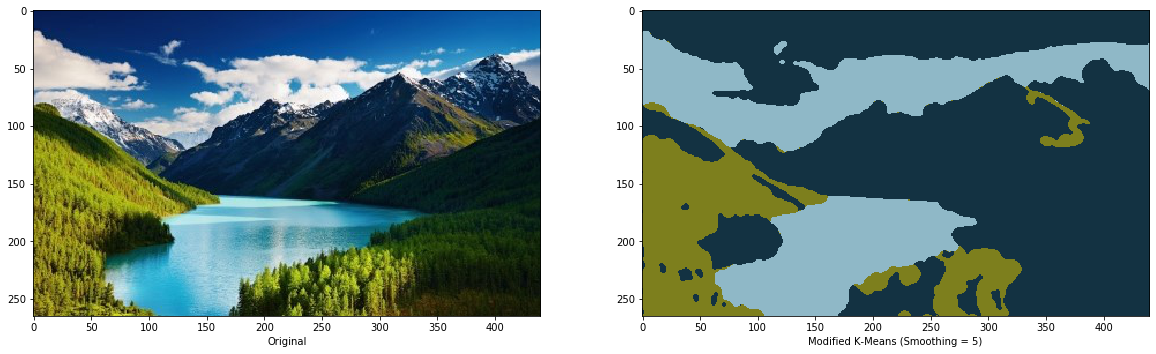

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(np.asarray(img_orig))
ax[1].imshow(np.asarray(img_compressed))

ax[0].set_xlabel("Original")
ax[1].set_xlabel("Modified K-Means (Smoothing = 5)")